# Lab 2: AutoML with Azure ML

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

In this example we use the associated credit card dataset to showcase how you can use AutoML for a simple classification problem. The goal is to predict if an employee will leave a company (employee churn).

This notebook is using remote compute to train the model.

If you are using an Azure Machine Learning Compute Instance, you are all set. Otherwise, go through the [configuration](../../../configuration.ipynb) notebook first if you haven't already to establish your connection to the AzureML Workspace. 

In this notebook you will learn how to:
1. Create an experiment using an existing workspace.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using remote compute.
4. Explore the results.
5. Test the fitted model.

> Azure AutoML documentation :
https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-automated-ml

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For Automated ML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [2]:
import datetime
now = datetime.datetime.now()
print('Date:', now)

Date: 2021-06-03 15:58:41.797847


In [3]:
import logging

from matplotlib import pyplot as plt
import pandas as pd
import os
import seaborn as sns

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig

In [4]:
import azureml.core
print("You are using Azure ML", azureml.core.VERSION)

You are using Azure ML 1.28.0


In [5]:
#!pip install --upgrade azureml-sdk
#!pip install --upgrade azureml-sdk[automl]

In [6]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'Lab2-AutoML'

experiment=Experiment(ws, experiment_name)

## Create or Attach existing AmlCompute
A compute target is required to execute the Automated ML run. In this tutorial, you create AmlCompute as your training compute resource.

If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [7]:
import random
randomval=round(random.random()*1000000)
ccname="automlclus"+str(randomval)
ccname

'automlclus222606'

In [8]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

#Use a unique name
cpu_cluster_name = ccname


try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_F4s_v2',
                                                           vm_priority='dedicated',
                                                           min_nodes=0, # use min_nodes=0 for automatic scaling down to 0 nodess
                                                           max_nodes=4,
                                                           idle_seconds_before_scaledown=18000) #you can reduce the timeout to avoid extra cost
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Creating.........
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [9]:
compute_target.provisioning_state

'Succeeded'

In [10]:
compute_target.serialize

<bound method AmlCompute.serialize of AmlCompute(workspace=Workspace.create(name='AMLworkshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='AMLworkshop-rg'), name=automlclus222606, id=/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourceGroups/AMLworkshop-rg/providers/Microsoft.MachineLearningServices/workspaces/AMLworkshop/computes/automlclus222606, type=AmlCompute, provisioning_state=Succeeded, location=westeurope, tags={})>

# Data

### Load Data

In [11]:
import urllib

In [12]:
url="https://raw.githubusercontent.com/retkowsky/DataSets-AutoML_AzureMLservice/master/Titanic.csv"
filename = 'titanic.csv'
urllib.request.urlretrieve(url, filename=filename)

('titanic.csv', <http.client.HTTPMessage at 0x7fe4b1ccbc50>)

In [13]:
!ls titanic.CSV -l

-rwxrwxrwx 1 root root 60302 Jun  3 15:59 titanic.CSV


In [14]:
datastore = ws.get_default_datastore()
datastore.upload_files(files = ['titanic.csv'],
                       target_path = 'train-dataset/tabular/',
                       overwrite = True,
                       show_progress = True)

Uploading an estimated of 1 files
Uploading titanic.csv
Uploaded titanic.csv, 1 files out of an estimated total of 1
Uploaded 1 files


$AZUREML_DATAREFERENCE_9c8f7683b88d45589d9d0b12c2020de3

In [15]:
from azureml.core import Dataset
dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 'train-dataset/tabular/titanic.csv')])

# preview the first 3 rows of the dataset
dataset.take(3).to_pandas_dataframe()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [16]:
training_data, validation_data = dataset.random_split(percentage=0.8, seed=223) #Partitionning the dataset
label_column_name = 'Survived' # Variable to predict

In [17]:
df=dataset.to_pandas_dataframe()

In [18]:
df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [ ]:
df.describe()

In [19]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [20]:
df.shape

(891, 12)

In [25]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [26]:
df.Survived.value_counts(normalize="true")

0    0.616162
1    0.383838
Name: Survived, dtype: float64

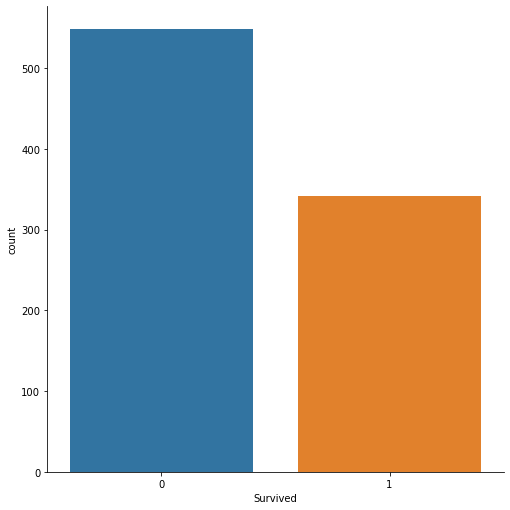

In [27]:
sns.catplot(x="Survived", kind="count", data=df, height=7)

## Let's save the dataset as an Azure ML dataset

In [28]:
tagsdataset= {"Type": "Test", 
              "Team": "DataScience",
              "Topic": "Titanic",
              "Country": "France",
              "Demo": "Yes",
              }

dataset = dataset.register(workspace=ws,
                           name='Titanic',
                           description='Dataset for AutoML',
                           create_new_version=True,
                           tags=tagsdataset)

In [29]:
dataset.name

'Titanic'

In [30]:
dataset.tags

{'Type': 'Test',
 'Team': 'DataScience',
 'Topic': 'Titanic',
 'Country': 'France',
 'Demo': 'Yes'}

In [31]:
dataset.version

2

## AutoML

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.


**_You can find more information about primary metrics_** [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)

Documentation AutoMLConfig : https://docs.microsoft.com/en-us/python/api/azureml-train-automl-client/azureml.train.automl.automlconfig.automlconfig?view=azure-ml-py

In [32]:
automl_settings = {
    "n_cross_validations": 3,          # Cross validation
    "primary_metric": 'precision_score_weighted',      # Metric
    "iterations": 10,                  # Number of max iterations
    "max_concurrent_iterations": 4,    # Max concurrent iterations
    "experiment_timeout_minutes": 15,  # Timeout in minutes full process
    "iteration_timeout_minutes": 5,    # Timeout per iteration
    "enable_early_stopping": True,     # Early Stopping
    "verbosity": logging.INFO,         # Verbosity
    "featurization": 'auto',           # Data Engineering preprocess
    "enable_stack_ensemble": False,    # No Stack ensemble modelling
    "enable_voting_ensemble" : False,  # No Vote ensemble modelling
    }

automl_config = AutoMLConfig(task = 'classification',               # Classification, Regression or Forecasting AutoML task
                             debug_log = 'automl.log',              # Log file
                             blocked_models=['XGBoostClassifier'],  # Models to exclude if needed.
                             compute_target = compute_target,       # Compute Target to use
                             training_data = training_data,         # Training dataset to use
                             label_column_name = label_column_name, # Target variable to explain
                             **automl_settings                      # Additional settings
                            )

Call the `submit` method on the experiment object and pass the run configuration. Depending on the data and the number of iterations this can run for a while. Validation errors and current status will be shown when setting `show_output=True` and the execution will be synchronous.

In [33]:
remote_run = experiment.submit(automl_config, show_output = True)

Submitting remote run.
No run_configuration provided, running on automlclus222606 with default configuration
Running on remote compute: automlclus222606


Experiment,Id,Type,Status,Details Page,Docs Page
Lab2-AutoML,AutoML_1a520446-53de-45ed-8114-0ffff381fa82,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation



Current status: FeaturesGeneration. Generating features for the dataset.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       DONE
DESCRIPTION:  If the missing values are expected, let the run complete. Otherwise cancel the current run and use a script to customize the handling of missing feature values that may be more appropriate based on the data type and business requirement.
              Learn more about missing value imputation: https://aka.ms/Automated

In [38]:
remote_run.get_status

<bound method Run.get_status of Run(Experiment: Lab2-AutoML,
Id: AutoML_1a520446-53de-45ed-8114-0ffff381fa82,
Type: automl,
Status: Completed)>

In [39]:
#remote_run.wait_for_completion(show_output=False)

In [40]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
Lab2-AutoML,AutoML_1a520446-53de-45ed-8114-0ffff381fa82,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [41]:
# We can have the list of all the runs from the current experiment
list_runs = experiment.get_runs()

for run in list_runs:
    print('Run ID:', run.id)

Run ID: AutoML_1a520446-53de-45ed-8114-0ffff381fa82
Run ID: AutoML_d5f56a31-65ce-4edc-bf99-a15e25149502
Run ID: AutoML_54fee7ef-3c07-4da3-b4a4-5b0c945897ce
Run ID: AutoML_435fc678-9cbe-4220-8dff-fe477f4d3c40
Run ID: AutoML_bc759f61-36cf-48ec-9771-9cda172112fe
Run ID: AutoML_acf9e3d4-9282-40e7-9b66-10935cfff3f9
Run ID: AutoML_4a6a4d43-fe80-4cf3-8be0-abcb6be5f844
Run ID: AutoML_17ac028c-4881-4934-9c81-5a5217708f4f
Run ID: AutoML_a8a7acd2-7ccb-4130-b678-bf7845354aa3
Run ID: AutoML_1e7d8f36-3d76-4dc3-a326-0de36cfdd9d8
Run ID: AutoML_061cf663-b190-4cad-a9ec-a1dab853bc46
Run ID: AutoML_6f863afc-6b15-4437-b98e-b5fc9e9264d0
Run ID: AutoML_6f49c184-0bd2-44d7-bc0f-dcf3c3f0073b
Run ID: AutoML_2594582d-e975-4755-a32d-ef61712881a5
Run ID: AutoML_ceac0041-3667-4abf-a8bf-4fc2f3887d8c
Run ID: AutoML_d70d9de3-6577-410f-ae0d-2c226350c2b5
Run ID: AutoML_036a4b20-2692-45f1-80ed-1a53bd81c9ae
Run ID: AutoML_3c4efcf1-739e-46fa-823d-e0d4ad69ac3d
Run ID: AutoML_61389ec3-6330-48bd-a1ad-54d557c87bf9
Run ID: Auto

## Results

#### Widget for Monitoring Runs

The widget will first report a "loading" status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.

**Note:** The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details

In [42]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Analyze results

### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method returns the best run and the fitted model.  Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [43]:
best_run, fitted_model = remote_run.get_output()

Package:azureml-automl-runtime, training version:1.29.0, current version:1.28.0.post2
Package:azureml-core, training version:1.29.0, current version:1.28.0
Package:azureml-dataset-runtime, training version:1.29.0, current version:1.28.0
Package:azureml-defaults, training version:1.29.0, current version:1.28.0
Package:azureml-interpret, training version:1.29.0, current version:1.28.0
Package:azureml-mlflow, training version:1.29.0, current version:1.28.0
Package:azureml-pipeline-core, training version:1.29.0, current version:1.28.0
Package:azureml-telemetry, training version:1.29.0, current version:1.28.0
Package:azureml-train-automl-client, training version:1.29.0, current version:1.28.0
Package:azureml-train-automl-runtime, training version:1.29.0, current version:1.28.0


## Test the fitted model

Now that the model is trained, split the data in the same way the data was split for training (The difference here is the data is being split locally) and then run the test data through the trained model to get the predicted values.

In [44]:
X_test_df = validation_data.drop_columns(columns=[label_column_name]).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()

In [45]:
y_pred = fitted_model.predict(X_test_df)
y_pred

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1])

### Confusion Matrix

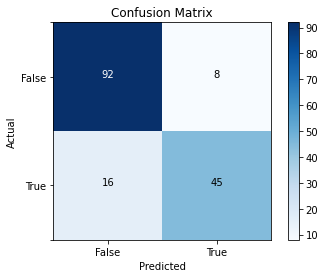

In [46]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])

# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

## All models

In [47]:
children = list(remote_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

mylist = pd.DataFrame(metricslist).sort_index(1)
mylist

,0,1,2,3,4,5,6,7,8,9
AUC_micro,0.85,0.78,0.76,0.84,0.83,0.82,0.85,0.87,0.85,0.86
matthews_correlation,0.55,0.48,0.10,0.54,0.54,0.54,0.55,0.57,0.55,0.57
balanced_accuracy,0.77,0.74,0.54,0.76,0.77,0.77,0.78,0.78,0.77,0.78
accuracy,0.79,0.74,0.64,0.78,0.78,0.78,0.78,0.80,0.79,0.80
log_loss,0.57,0.67,0.60,0.51,0.53,0.53,0.49,0.46,2.14,0.53
precision_score_macro,0.78,0.74,0.43,0.77,0.77,0.77,0.77,0.80,0.78,0.79
norm_macro_recall,0.55,0.48,0.08,0.53,0.54,0.55,0.55,0.55,0.54,0.56
f1_score_micro,0.79,0.74,0.64,0.78,0.78,0.78,0.78,0.80,0.79,0.80
f1_score_macro,0.78,0.74,0.46,0.77,0.77,0.77,0.77,0.78,0.77,0.78
f1_score_weighted,0.79,0.75,0.53,0.78,0.78,0.78,0.78,0.79,0.78,0.80


## Best Model

In [48]:
best_run, fitted_model = remote_run.get_output()
print("Best AutoML run =", best_run)

Package:azureml-automl-runtime, training version:1.29.0, current version:1.28.0.post2
Package:azureml-core, training version:1.29.0, current version:1.28.0
Package:azureml-dataset-runtime, training version:1.29.0, current version:1.28.0
Package:azureml-defaults, training version:1.29.0, current version:1.28.0
Package:azureml-interpret, training version:1.29.0, current version:1.28.0
Package:azureml-mlflow, training version:1.29.0, current version:1.28.0
Package:azureml-pipeline-core, training version:1.29.0, current version:1.28.0
Package:azureml-telemetry, training version:1.29.0, current version:1.28.0
Package:azureml-train-automl-client, training version:1.29.0, current version:1.28.0
Package:azureml-train-automl-runtime, training version:1.29.0, current version:1.28.0


Best AutoML run = Run(Experiment: Lab2-AutoML,
Id: AutoML_1a520446-53de-45ed-8114-0ffff381fa82_9,
Type: azureml.scriptrun,
Status: Completed)


In [49]:
fitted_model.steps

[('datatransformer',
  DataTransformer(
      task='classification',
      is_onnx_compatible=False,
      enable_feature_sweeping=True,
      enable_dnn=False,
      force_text_dnn=False,
      feature_sweeping_timeout=86400,
      featurization_config=None,
      is_cross_validation=True,
      feature_sweeping_config={}
  )),
 ('TruncatedSVDWrapper',
  TruncatedSVDWrapper(n_components=0.95, random_state=None)),
 ('LogisticRegression',
  LogisticRegression(C=11.513953993264458, class_weight=None, dual=False,
                     fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                     max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
                     random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                     warm_start=False))]

In [50]:
print(fitted_model)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=True, is_onnx_compatible=False, observer=None, task='classification', working_dir='/mnt/batch/tasks/shared/LS_root/mount...
                ('TruncatedSVDWrapper',
                 TruncatedSVDWrapper(n_components=0.95, random_state=None)),
                ('LogisticRegression',
                 LogisticRegression(C=11.513953993264458, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=100, multi_class='ovr', n_jobs=1,
                                    penalty='l2', random_state=None,
                                    solver='newton-cg', tol=0.0001, verbose=0,
        

In [51]:
fitted_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=True, is_onnx_compatible=False, observer=None, task='classification', working_dir='/mnt/batch/tasks/shared/LS_root/mount...
                ('TruncatedSVDWrapper',
                 TruncatedSVDWrapper(n_components=0.95, random_state=None)),
                ('LogisticRegression',
                 LogisticRegression(C=11.513953993264458, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=100, multi_class='ovr', n_jobs=1,
                                    penalty='l2', random_state=None,
                                    solver='newton

In [52]:
print("Metrics of the best model:")
print()
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print('-', metric_name, '=', metric)

Metrics of the best model:

- AUC_macro = 0.8501241668166332
- recall_score_micro = 0.7986293822662979
- average_precision_score_weighted = 0.8528267935772732
- precision_score_macro = 0.7937746913429587
- matthews_correlation = 0.5739898149748536
- precision_score_micro = 0.7986293822662979
- norm_macro_recall = 0.5613827750050661
- f1_score_weighted = 0.7963117458438509
- average_precision_score_macro = 0.8449692062424937
- AUC_weighted = 0.8501241668166332
- recall_score_macro = 0.7806913875025329
- recall_score_weighted = 0.7986293822662979
- weighted_accuracy = 0.8149176562646264
- average_precision_score_micro = 0.8532778065928182
- accuracy = 0.7986293822662979
- log_loss = 0.5300148747146466
- f1_score_macro = 0.7832894660605335
- balanced_accuracy = 0.7806913875025329
- AUC_micro = 0.8627995707879896
- f1_score_micro = 0.7986293822662979
- precision_score_weighted = 0.8011715688683364
- confusion_matrix = aml://artifactId/ExperimentRun/dcid.AutoML_1a520446-53de-45ed-8114-0ffff

## We can choose any iteration

In [53]:
iteration = 2

my_run, my_model = remote_run.get_output(iteration = iteration)
print("Model",iteration," iteration :")
print(my_run)
print()
print(my_model)

Package:azureml-automl-runtime, training version:1.29.0, current version:1.28.0.post2
Package:azureml-core, training version:1.29.0, current version:1.28.0
Package:azureml-dataset-runtime, training version:1.29.0, current version:1.28.0
Package:azureml-defaults, training version:1.29.0, current version:1.28.0
Package:azureml-interpret, training version:1.29.0, current version:1.28.0
Package:azureml-mlflow, training version:1.29.0, current version:1.28.0
Package:azureml-pipeline-core, training version:1.29.0, current version:1.28.0
Package:azureml-telemetry, training version:1.29.0, current version:1.28.0
Package:azureml-train-automl-client, training version:1.29.0, current version:1.28.0
Package:azureml-train-automl-runtime, training version:1.29.0, current version:1.28.0


Model 2  iteration :
Run(Experiment: Lab2-AutoML,
Id: AutoML_1a520446-53de-45ed-8114-0ffff381fa82_2,
Type: azureml.scriptrun,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=True, is_onnx_compatible=False, observer=None, task='classification', working_dir='/mnt/batch/tasks/shared/LS_root/mount...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                          

### We want to keep the best model

In [54]:
best_run, fitted_model = remote_run.get_output()
print(best_run)
print()
print(fitted_model)
print()
print("Metrics:")
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, '=', metric)

Package:azureml-automl-runtime, training version:1.29.0, current version:1.28.0.post2
Package:azureml-core, training version:1.29.0, current version:1.28.0
Package:azureml-dataset-runtime, training version:1.29.0, current version:1.28.0
Package:azureml-defaults, training version:1.29.0, current version:1.28.0
Package:azureml-interpret, training version:1.29.0, current version:1.28.0
Package:azureml-mlflow, training version:1.29.0, current version:1.28.0
Package:azureml-pipeline-core, training version:1.29.0, current version:1.28.0
Package:azureml-telemetry, training version:1.29.0, current version:1.28.0
Package:azureml-train-automl-client, training version:1.29.0, current version:1.28.0
Package:azureml-train-automl-runtime, training version:1.29.0, current version:1.28.0


Run(Experiment: Lab2-AutoML,
Id: AutoML_1a520446-53de-45ed-8114-0ffff381fa82_9,
Type: azureml.scriptrun,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=False, enable_feature_sweeping=True, feature_sweeping_config={}, feature_sweeping_timeout=86400, featurization_config=None, force_text_dnn=False, is_cross_validation=True, is_onnx_compatible=False, observer=None, task='classification', working_dir='/mnt/batch/tasks/shared/LS_root/mount...
                ('TruncatedSVDWrapper',
                 TruncatedSVDWrapper(n_components=0.95, random_state=None)),
                ('LogisticRegression',
                 LogisticRegression(C=11.513953993264458, class_weight=None,
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=100, multi_class='ovr', n_jobs=1,
                               

In [55]:
for step in fitted_model.named_steps:
    print(step)

datatransformer
TruncatedSVDWrapper
LogisticRegression


In [56]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', 
                        model_name='BestAutoMLModel',
                        tags={'Training Context':'Azure Auto ML', 
                              'Compute Cluster':'Yes', 
                              'Topic':'Titanic'},
                        properties={'AUC': best_run_metrics['AUC_weighted'], 
                                    'Average Precision Score': best_run_metrics['average_precision_score_weighted'],
                                    'Accuracy': best_run_metrics['accuracy'],
                                    'Precision': best_run_metrics['precision_score_weighted']}
                       )

Model(workspace=Workspace.create(name='AMLworkshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='AMLworkshop-rg'), name=BestAutoMLModel, id=BestAutoMLModel:29, version=29, tags={'Training Context': 'Azure Auto ML', 'Compute Cluster': 'Yes', 'Topic': 'Titanic'}, properties={'AUC': '0.8501241668166332', 'Average Precision Score': '0.8528267935772732', 'Accuracy': '0.7986293822662979', 'Precision': '0.8011715688683364'})

In [57]:
best_run.properties

{'runTemplate': 'automl_child',
 'pipeline_id': 'b6fda4855c36d32d9ba9e802a7271a2a0b12297b',
 'pipeline_spec': '{"objects": [{"class_name": "TruncatedSVDWrapper", "module": "automl.client.core.common.model_wrappers", "param_args": [], "param_kwargs": {"n_components": 0.95}, "prepared_kwargs": {}, "spec_class": "preproc"}, {"class_name": "LogisticRegression", "module": "sklearn.linear_model", "param_args": [], "param_kwargs": {"C": 11.513953993264458, "class_weight": null, "multi_class": "ovr", "penalty": "l2", "solver": "newton-cg"}, "prepared_kwargs": {}, "spec_class": "sklearn"}], "pipeline_id": "b6fda4855c36d32d9ba9e802a7271a2a0b12297b", "module": "sklearn.pipeline", "class_name": "Pipeline", "pipeline_name": "{ TruncatedSVDWrapper, LogisticRegression }"}',
 'training_percent': '100',
 'predicted_cost': '0.048137982598779',
 'iteration': '9',
 '_aml_system_scenario_identification': 'Remote.Child',
 '_azureml.ComputeTargetType': 'amlcompute',
 'ContentSnapshotId': '5aa4f2c1-e73c-4a9a-

In [58]:
experiment

Name,Workspace,Report Page,Docs Page
Lab2-AutoML,AMLworkshop,Link to Azure Machine Learning studio,Link to Documentation


> You can open now the **Lab3 notebook**.

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">